# 네이버 쇼핑 리뷰 데이터에 대한 이해와 전처리

# [1] Colab에 한글 형태소 Okt 실습하기

In [1]:
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
!pip install konlpy
from konlpy.tag import Okt

In [3]:
import pandas as pd
df=pd.read_csv("https://raw.githubusercontent.com/hongsukyi/Lectures/main/data/naver_shopping.txt", header=None,sep="\t")

In [4]:
df.columns = ['ratings', 'reviews']; df.head()

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


- 교육용 데이터 크기를 줄이자. 15,000개

In [5]:
df=df[:5000]; len(df)

5000

- ratings > 3 긍정(1), 2이하이면 부정(0)
- 넘파이 np.select
- 판다스에 새로운 컬럼 'label'을 추가함


In [6]:
import numpy as np
df['label'] = np.select([df.ratings > 3], [1], default=0)
df.head()

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [7]:
df['ratings'].nunique(), df['reviews'].nunique(), df['label'].nunique()

(4, 5000, 2)

<Axes: xlabel='label'>

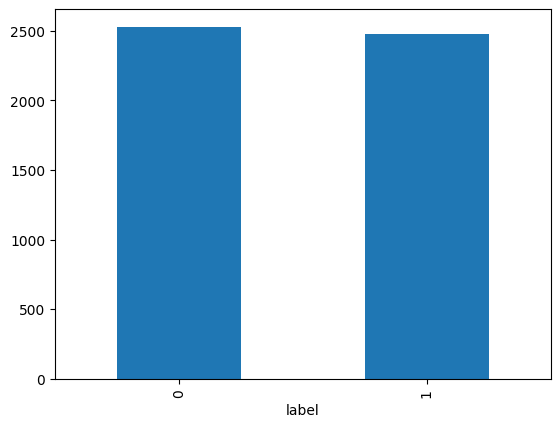

In [8]:
df['label'].value_counts().plot(kind = 'bar')

한글과 공백을 제외하고 모두 제거

In [9]:
df['reviews'] = df['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

### 2. 한글 형태소 Okt 활용하기

In [10]:
okt = Okt()
print(okt.morphs('택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고'))

['택배', '가', '엉망', '이네', '용', '저희', '집', '밑', '에', '층', '에', '말', '도', '없이', '놔두고가고']


In [11]:
stopwords = ['도','는','다','의','가','이','은','한','에','하','고','을','를','인','듯','과','와','네','들','듯','지','임','게']

In [12]:
df['tokenized'] = df['reviews'].apply(okt.morphs)
df['tokenized'] = df['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [13]:
df['tokenized'].head()

0                                         [배공, 빠르고, 굿]
1           [택배, 엉망, 이네, 용, 저희, 집, 밑, 층, 말, 없이, 놔두고가고]
2    [아주, 좋아요, 바지, 정말, 좋아서, 2, 개, 더, 구매, 했어요, 가격, 대...
3    [선물, 용, 으로, 빨리, 받아서, 전달, 했어야, 하는, 상품, 이었는데, 머그...
4      [민트, 색상, 예뻐요, ., 옆, 손잡이, 거, 용, 도로, 사용, 되네요, ㅎㅎ]
Name: tokenized, dtype: object

긍정 리뷰의 평균 길이 : 11.824100283057016


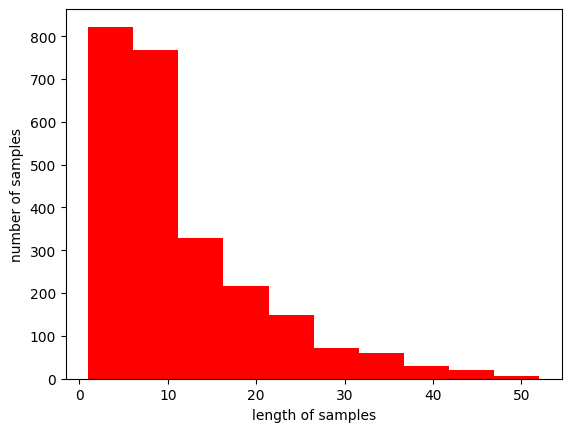

In [14]:
import matplotlib.pyplot as plt
text_len = df[df['label']==1]['tokenized'].map(lambda x: len(x))
plt.hist(text_len, color='red')
plt.xlabel('length of samples')
plt.ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

# [2] 케라스를 이용한 토큰화 실습

In [35]:
X_train = df['tokenized'].values
y_train = df['label'].values

In [36]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [37]:
vocab_size = 8000
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)

In [38]:
print(X_train[:3])

[[3475, 57, 304], [217, 557, 113, 111, 872, 177, 558, 1507, 385, 149, 5318], [75, 8, 662, 49, 213, 83, 42, 33, 11, 54, 23, 955, 28, 2, 2606, 61, 801, 5319, 305, 282, 158, 104, 251, 136, 2]]


### 4. 토큰화된 텍스트를 패딩(padding)하기

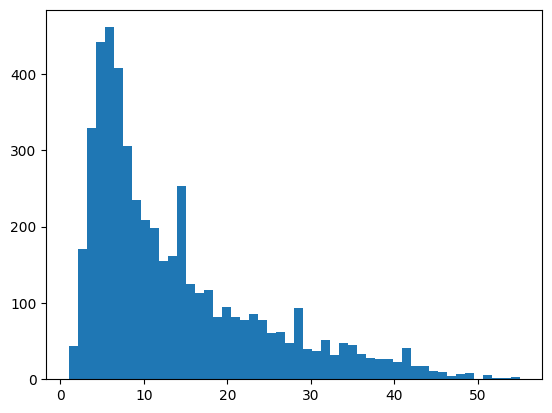

In [39]:
plt.hist([len(s) for s in X_train], bins=50)
plt.show()

In [40]:
max_len = 60   # 한 문장에서 리뷰 길이(개수)는 60이면 충분하다. 
X_train = pad_sequences(X_train, maxlen = max_len)

- max_len = 50 : 리뷰 문장 1개의 고정 길이(패딩)
- vocab_size = 5,000 : BoW의 길이
- 샘플의 길이 = 2,000
-X_train.shape의 크기는 (2000, 50)이다.


In [41]:
X_train.shape

(5000, 60)

In [42]:
X_train[:1], y_train[:1]

(array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0, 3475,   57,  304]]),
 array([1]))

# [3] SimpleRNN을 이용한 네이버 쇼핑 리뷰 분류하기

In [43]:
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN, GRU, LSTM, Flatten
from tensorflow.keras.models import Sequential

In [44]:
emb_dim = 64
rnn_hiddens = 128 

In [45]:
model = Sequential()
model.add(Embedding(vocab_size, emb_dim))
model.add(SimpleRNN(rnn_hiddens))
model.add(Dense(32))
model.add(Dense(1, activation='sigmoid'))

In [46]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2)

Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - acc: 0.5451 - loss: 0.7107 - val_acc: 0.7730 - val_loss: 0.5347
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - acc: 0.8259 - loss: 0.4281 - val_acc: 0.7880 - val_loss: 0.4679
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - acc: 0.9215 - loss: 0.2231 - val_acc: 0.8040 - val_loss: 0.5053
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - acc: 0.9555 - loss: 0.1353 - val_acc: 0.7760 - val_loss: 0.5990
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - acc: 0.9772 - loss: 0.0627 - val_acc: 0.6930 - val_loss: 0.8535
Epoch 6/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - acc: 0.9665 - loss: 0.1397 - val_acc: 0.8080 - val_loss: 0.5708
Epoch 7/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - acc: 0.9637 - loss: 0.1769 - val_acc: 0.8030 - val_loss: 0.6139
Epoch 8/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - acc: 0.9783 - loss: 0.0809 - val_acc: 0.7440 - val_loss: 0.8144
Epoch 9/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/

In [47]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (32, 60, 64)                │         512,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (32, 128)                   │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 32)                    │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 1)                     │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,081,732 (4.13 MB)

 Trainable params: 540,865 (2.06 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 540,867 (2.06 MB)

### 리뷰 예측해보기

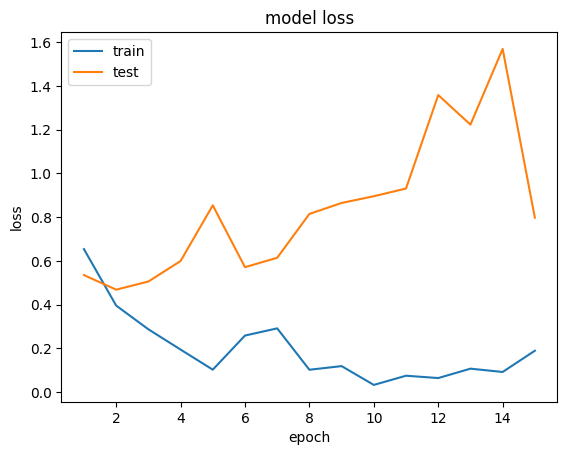

In [48]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

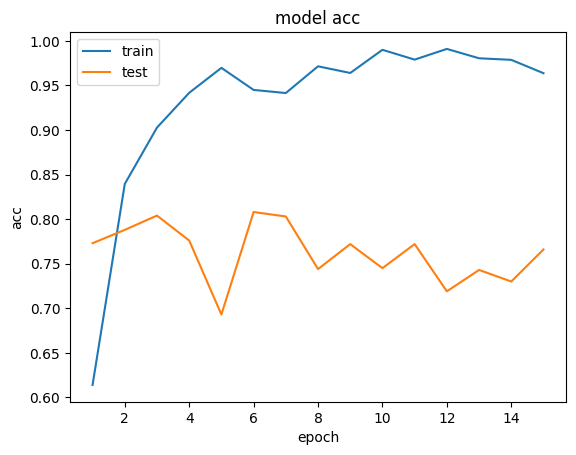

In [49]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [50]:
import re
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩

  score = float(model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [51]:
sentiment_predict('이 상품 진짜 좋아요... 저는 강추합니다. 대박')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
97.80% 확률로 긍정 리뷰입니다.


In [52]:
sentiment_predict('진짜 배송도 늦고 개짜증나네요. 뭐 이런 걸 상품이라고 만듬?')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
98.20% 확률로 부정 리뷰입니다.


In [53]:
sentiment_predict('판매자님... 너무 짱이에요.. 대박나삼')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
95.45% 확률로 부정 리뷰입니다.


In [54]:
sentiment_predict('ㅁㄴㅇㄻㄴㅇㄻㄴㅇ리뷰쓰기도 귀찮아')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
92.45% 확률로 긍정 리뷰입니다.
